# Instalando dependêndcias

In [1]:
%%capture
!pip install sidetable



# Importando dependências


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sidetable as stb
from tqdm.notebook import tqdm
from google.colab import drive
import regex as re


import string
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from transformers import (AutoTokenizer,
                          AutoModelForSequenceClassification,)
from sklearn.feature_extraction.text import CountVectorizer



from scipy.special import softmax


import warnings

warnings.filterwarnings("ignore")

# Funcões necessárias para o trabalho


In [3]:
def eda(df:pd.DataFrame):
  '''
  Retornara um analise exploratoria simples

  -param df: pandas dataframe
  '''
  print("-"*30,"DataFrame Shape", "-"*30)
  print(df.shape)
  print("-"*30,"DataFrame info", "-"*30)
  print(df.info())
  print("-"*30,"DataFrame Nan", "-"*30)
  print(df.isna().sum())
  print("-"*30,"DataFrame duplicated", "-"*30)
  print(df.duplicated().sum())
  print("-"*30,"DataFrame nunique", "-"*30)
  print(df.nunique())


def date_engineering(df:pd.DataFrame)->pd.DataFrame:
  '''
  Retorna um pandas dataframe novo com colunas adicionais como mes, dia da semana,
  trimestre, ano, mes
  -param df: pandas dataframe
  '''
  df["month"]=df["date"].dt.month
  df["day_week"]=df["date"].dt.dayofweek
  df["quarter"]=df["date"].dt.quarter
  df["year"]=df["date"].dt.year
  df["month"]=df["date"].dt.month
  return df


def convert_lower_case(column):
  '''
  Funcao que retorna a coluna selecionada para letra minuscula
  -param column: coluna da pd.Dataframe
  '''
  return column.lower()


def remove_noise(column):
  '''
  Funcao para remover pontuacao, espacos extras, numeros e caracteres especiais

  '''
  column = re.sub("(@[A-Za-z0–9_]+)","", column)
  column = " ".join([char if char not in string.punctuation else " " for char in column])
  column = re.sub(' + ', '' , column)
  column = re.sub("[0–9]+", "", column)
  column = re.sub("[^A-Za-z0–9_. ]+","",column)

  return column

def remove_stop_words(column):
  tokenize=word_tokenize(column)
  column_withno_stopwords=[token for token in tokenize  if not token in my_stop_words ]
  new_sentence=" ".join(column_withno_stopwords)
  return new_sentence



In [4]:
#definindo quais serao meus stop-words para a limpeza do texto

nltk.download("stopwords")
my_stop_words=stopwords.words("english")

words2keep=["don", "don’t", "ain", "aren", "aren’t", "couldn", "couldn’t", "didn",
 "didn’t", "doesn", "doesn’t", "hadn", "hadn’t", "hasn", "hasn't", "haven", "haven’t", "isn", "isn’t", "ma",
 "mightn", "mightn't", "mustn", "mustn’t", "needn", "needn't", "shan", "shan't", "no", "nor", "not", "shouldn'",
 "shouldn't", "wasn'", "wasn't", "weren'", "weren't", "won", "won't", "wouldn'", "wouldn't"]

my_stop_words=[word for word in my_stop_words if word not in words2keep]
print(my_stop_words)


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', '

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
#dataset contendo alguns erros
drive.mount('/content/drive')
df=pd.read_csv("/content/drive/MyDrive/Sentimen analysis/Reviews.csv",encoding='utf-8',engine='python',error_bad_lines=False, sep=",")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [7]:
#trasformando a coluna text para lower case
df["Text"]=df["Text"].apply(lambda x : convert_lower_case(x))

In [8]:
eda(df)

------------------------------ DataFrame Shape ------------------------------
(568454, 10)
------------------------------ DataFrame info ------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB
None
-----------------------------

In [9]:

#transformando a coluna TIME em datetime[ns]
df["date"]=pd.to_datetime(df.Time, unit='s')
df1=df.sort_values(by="date", ascending=True).copy()


In [10]:
#criando colunas adicionais para date
df1=date_engineering(df1)
df1.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,date,month,day_week,quarter,year
150523,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,5,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,1999-10-08,10,4,4,1999
150500,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,5,940809600,This whole series is great way to spend time w...,i can remember seeing the show when it aired o...,1999-10-25,10,0,4,1999
451855,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,5,944092800,Entertainingl Funny!,beetlejuice is a well written movie ..... ever...,1999-12-02,12,3,4,1999
230284,230285,B00004RYGX,A344SMIA5JECGM,Vincent P. Ross,1,2,5,944438400,A modern day fairy tale,"a twist of rumplestiskin captured on film, sta...",1999-12-06,12,0,4,1999
451877,451878,B00004CXX9,A344SMIA5JECGM,Vincent P. Ross,1,2,5,944438400,A modern day fairy tale,"a twist of rumplestiskin captured on film, sta...",1999-12-06,12,0,4,1999


In [11]:
df1["Summary"][150500]

'This whole series is great way to spend time with your child'

In [12]:
df1.loc[(df1["UserId"]=="A3TVZM3ZIXG8YW")]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,date,month,day_week,quarter,year
426315,426316,B003BJOORW,A3TVZM3ZIXG8YW,christopher hayes,33,48,1,1291420800,"Filler food is empty, leaves your cat always n...","this review will make me sound really stupid, ...",2010-12-04,12,5,4,2010
96897,96898,B003WK0D8O,A3TVZM3ZIXG8YW,christopher hayes,6,15,1,1291420800,"Filler food is empty, leaves your cat always n...","this review will make me sound really stupid, ...",2010-12-04,12,5,4,2010
369795,369796,B000084DWM,A3TVZM3ZIXG8YW,christopher hayes,11,15,1,1291420800,"Filler food is empty, leaves your cat always n...","this review will make me sound really stupid, ...",2010-12-04,12,5,4,2010
247051,247052,B003M5TG28,A3TVZM3ZIXG8YW,christopher hayes,18,24,1,1291420800,"Filler food is empty, leaves your cat always n...","this review will make me sound really stupid, ...",2010-12-04,12,5,4,2010
145025,145026,B003MA8P02,A3TVZM3ZIXG8YW,christopher hayes,6,15,1,1291420800,"Filler food is empty, leaves your cat always n...","this review will make me sound really stupid, ...",2010-12-04,12,5,4,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354443,354444,B001VIY8BW,A3TVZM3ZIXG8YW,christopher hayes,2,4,1,1291420800,"Filler food is empty, leaves your cat always n...","this review will make me sound really stupid, ...",2010-12-04,12,5,4,2010
489993,489994,B002Z9EQQ8,A3TVZM3ZIXG8YW,christopher hayes,7,11,1,1291420800,"Filler food is empty, leaves your cat always n...","this review will make me sound really stupid, ...",2010-12-04,12,5,4,2010
247110,247111,B003M5TG28,A3TVZM3ZIXG8YW,christopher hayes,2,4,1,1291420800,"Filler food is empty, leaves your cat always n...","this review will make me sound really stupid, ...",2010-12-04,12,5,4,2010
354389,354390,B001VIY8BW,A3TVZM3ZIXG8YW,christopher hayes,3,3,1,1291420800,"Filler food is empty, leaves your cat always n...","this review will make me sound really stupid, ...",2010-12-04,12,5,4,2010


# Data understanding

### Padrao por Usuario

In [13]:
#temos 1 cliente dos top 20 clientes que mais escreveram Reviews  que classificou todos
#os produtos que ele comprou como nota 1
(df1.groupby("UserId")
 .agg(qtd_reviews=("Text","count"),
     resumo=("Summary","nunique"),
     media_score=("Score","mean")).
 sort_values("qtd_reviews", ascending=False)
 .head(20))

,qtd_reviews,resumo,media_score
UserId,,,
A3OXHLG6DIBRW8,448,259,4.535714
A1YUL9PCJR3JTY,421,198,4.494062
AY12DBB0U420B,389,325,4.647815
A281NPSIMI1C2R,365,249,4.841096
A1Z54EM24Y40LL,256,187,4.453125
A1TMAVN4CEM8U8,204,44,4.833333
A2MUGFV2TDQ47K,201,160,3.751244
A3TVZM3ZIXG8YW,199,1,1.000000
A3PJZ8TU8FDQ1K,178,70,4.601124


# Entendimento sobre notas

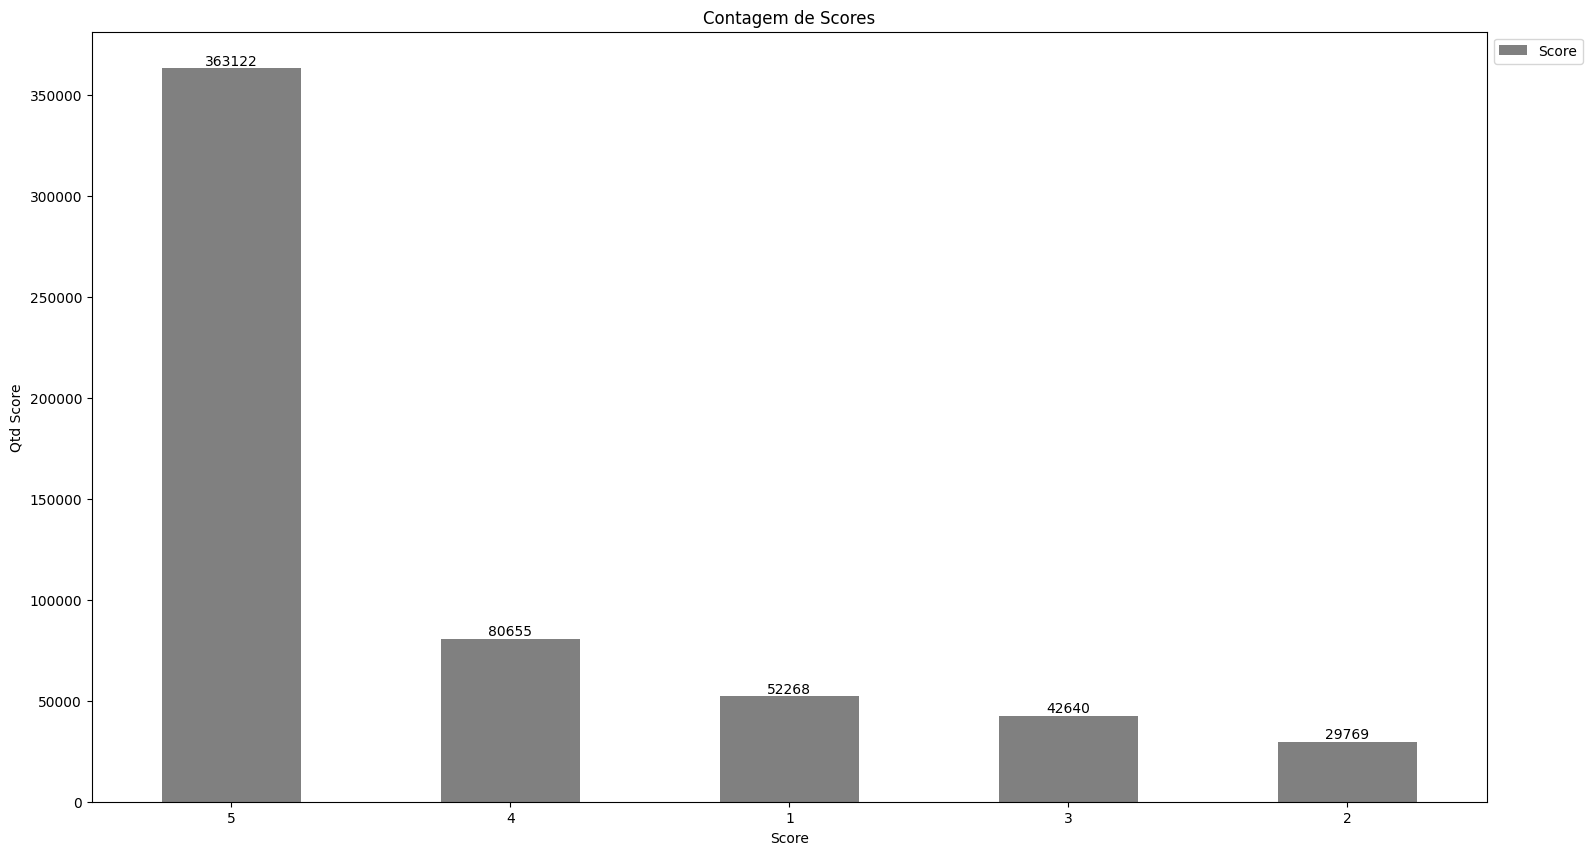

In [14]:
ax=df1["Score"].value_counts().plot(kind="bar",figsize=(18,10), color="gray")
ax.set_xlabel("Score")
ax.set_ylabel("Qtd Score")
plt.xticks(rotation=360)
ax.set_title("Contagem de Scores")
for label in ax.containers:
        ax.bar_label(label)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()


* 0->Monday
* 1->Tuesday
* 2->Wendnesday
* 3-Thursday
* 4-Friday
* 5-Saturday
* 6->Sunday

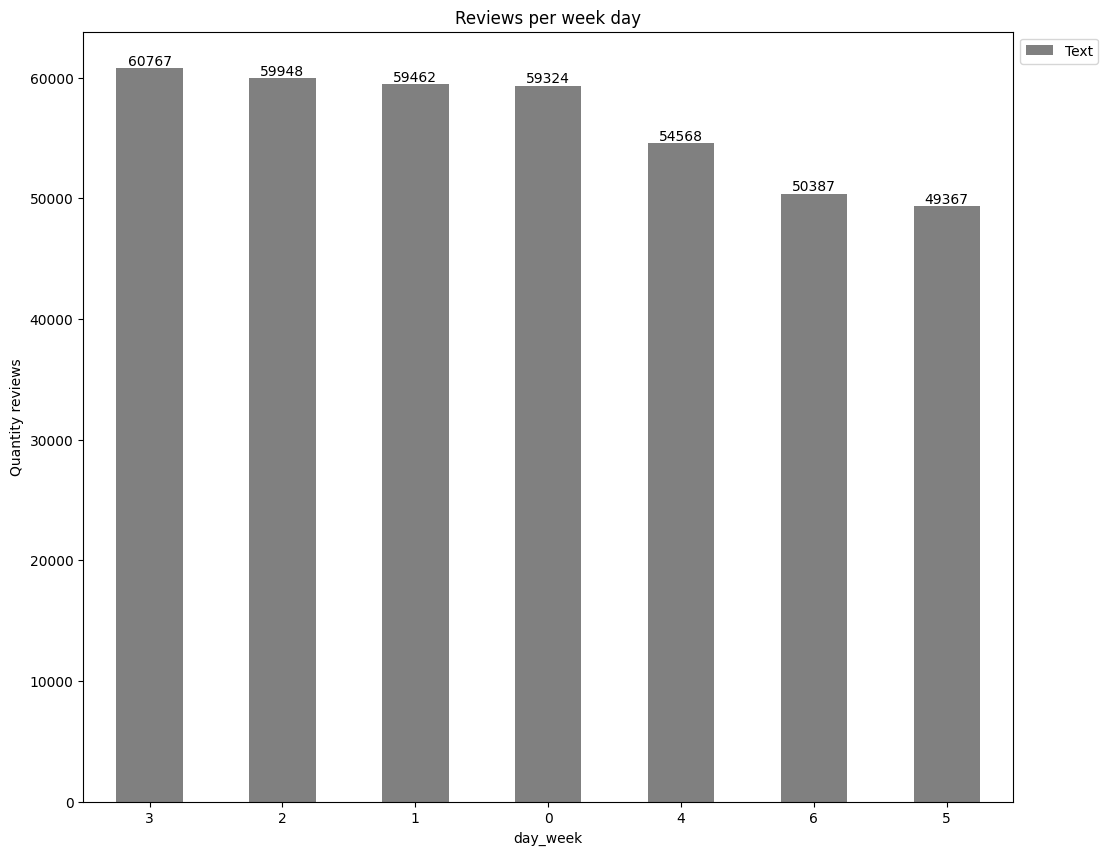

In [15]:
ax=(df1.groupby("day_week")
.agg({"Text":"nunique"})
.sort_values(by="Text", ascending=False)).plot(kind="bar",figsize=(12,10), color="gray")
plt.title("Reviews per week day")
plt.xticks(rotation=360)
plt.ylabel("Quantity reviews")
for label in ax.containers:
        ax.bar_label(label)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()


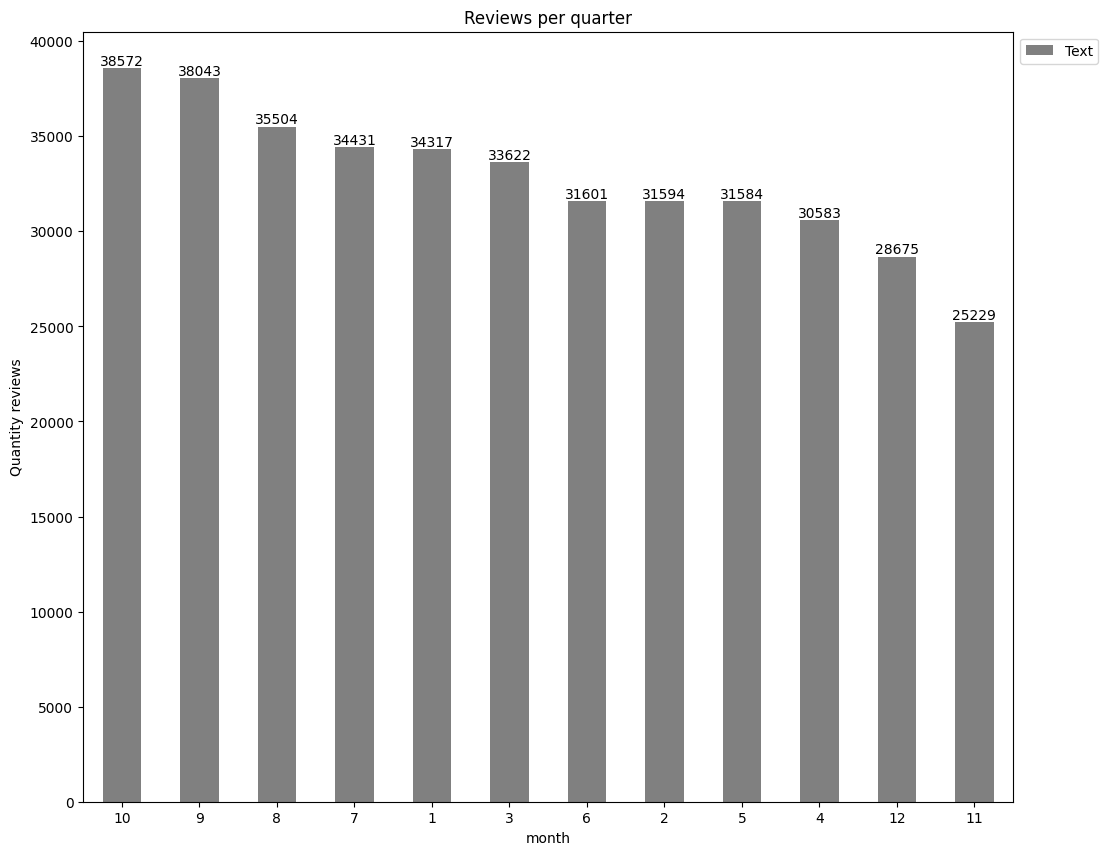

In [16]:
#Reviews por mes
ax=(df1.groupby("month")
.agg({"Text":"nunique"})
.sort_values(by="Text", ascending=False)).plot(kind="bar",figsize=(12,10), color="gray")
plt.title("Reviews per quarter")
plt.ylabel("Quantity reviews")
plt.xticks(rotation=360)
for label in ax.containers:
        ax.bar_label(label)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

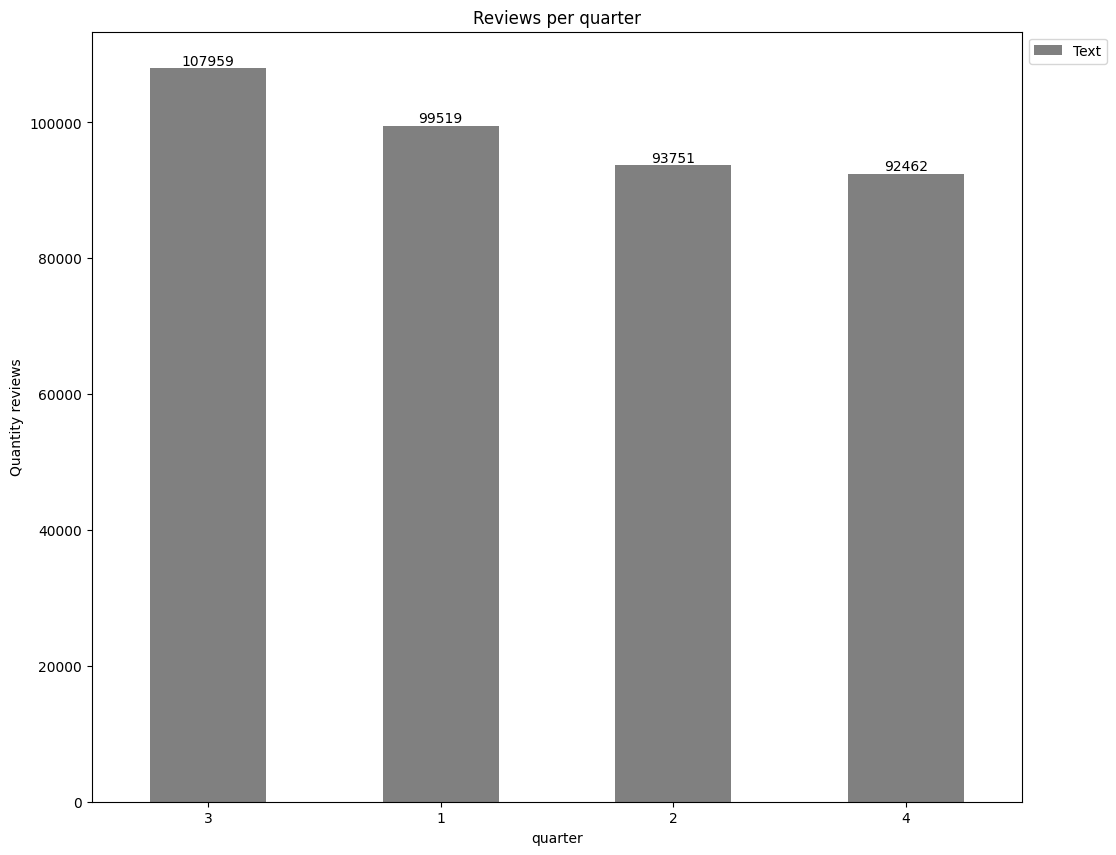

In [17]:
ax=(df1.groupby("quarter")
.agg({"Text":"nunique"})
.sort_values(by="Text", ascending=False)).plot(kind="bar",figsize=(12,10), color="gray")
plt.title("Reviews per quarter")
plt.xticks(rotation=360)
plt.ylabel("Quantity reviews")
for label in ax.containers:
        ax.bar_label(label)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

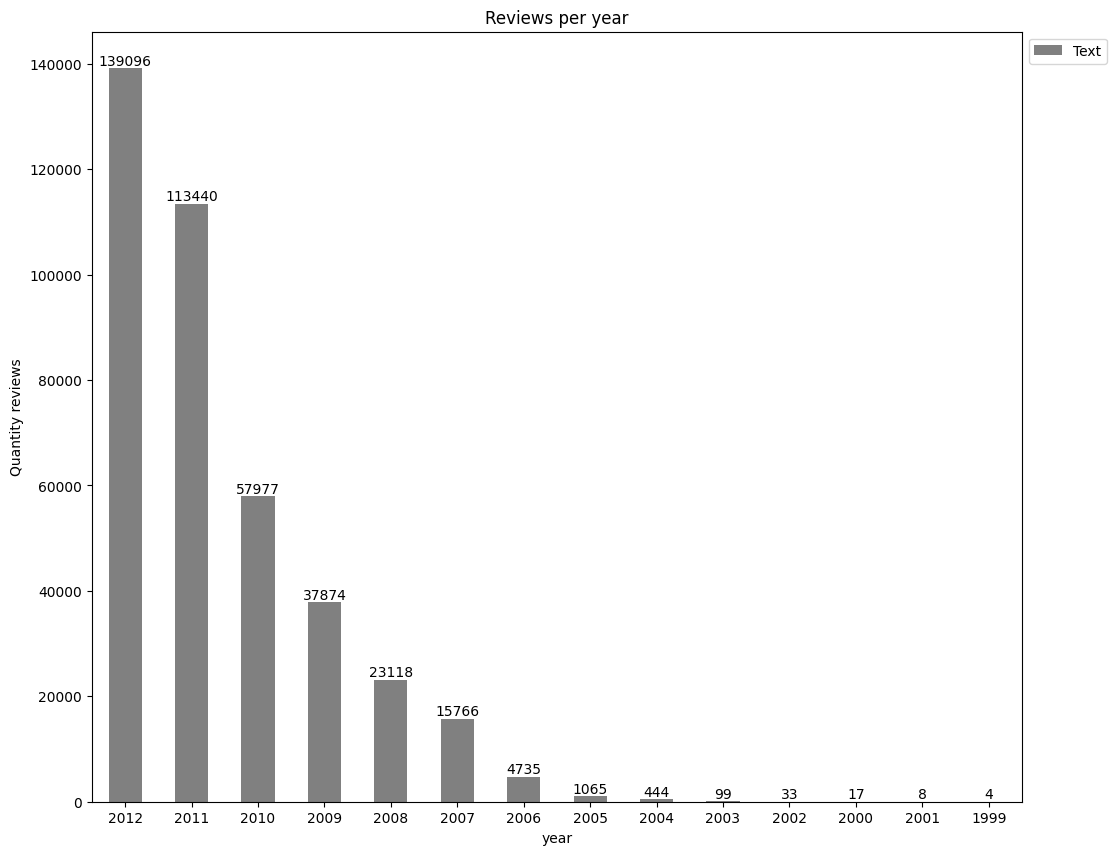

In [18]:
#Reviews por ano
ax=(df1.groupby("year")
.agg({"Text":"nunique"})
.sort_values(by="Text", ascending=False)).plot(kind="bar",figsize=(12,10), color="gray")
plt.title("Reviews per year")
plt.ylabel("Quantity reviews")
plt.xticks(rotation=360)
for label in ax.containers:
        ax.bar_label(label)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [19]:
#Reviews por  trimestre e ano
(df1.groupby(["year", "quarter"])
.agg({"Text":"nunique"})
.sort_values(by="Text", ascending=False)
.reset_index()
.head(16))

,year,quarter,Text
0,2012,3,44337
1,2012,1,41534
2,2012,2,38685
3,2011,4,36038
4,2011,3,28568
5,2011,1,24940
6,2011,2,23905
7,2010,4,17997
8,2010,3,14875
9,2012,4,14552


In [20]:
(df1.groupby(["day_week","Score"])
.agg(qtd_avaliacao=("day_week","count"))
.reset_index()
.sort_values(by="qtd_avaliacao", ascending=False))

,day_week,Score,qtd_avaliacao
4,0,5,54939
9,1,5,54635
14,2,5,53912
19,3,5,53696
24,4,5,51246
34,6,5,47980
29,5,5,46714
18,3,4,13345
13,2,4,12406
8,1,4,12308


# NLTK

In [21]:
df1.head(10)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,date,month,day_week,quarter,year
150523,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,5,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,1999-10-08,10,4,4,1999
150500,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,5,940809600,This whole series is great way to spend time w...,i can remember seeing the show when it aired o...,1999-10-25,10,0,4,1999
451855,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,5,944092800,Entertainingl Funny!,beetlejuice is a well written movie ..... ever...,1999-12-02,12,3,4,1999
230284,230285,B00004RYGX,A344SMIA5JECGM,Vincent P. Ross,1,2,5,944438400,A modern day fairy tale,"a twist of rumplestiskin captured on film, sta...",1999-12-06,12,0,4,1999
451877,451878,B00004CXX9,A344SMIA5JECGM,Vincent P. Ross,1,2,5,944438400,A modern day fairy tale,"a twist of rumplestiskin captured on film, sta...",1999-12-06,12,0,4,1999
374358,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,5,944438400,A modern day fairy tale,"a twist of rumplestiskin captured on film, sta...",1999-12-06,12,0,4,1999
451854,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,5,946857600,FANTASTIC!,beetlejuice is an excellent and funny movie. k...,2000-01-03,1,0,1,2000
374421,374422,B00004CI84,A1048CYU0OV4O8,Judy L. Eans,2,2,5,947376000,GREAT,this is one movie that should be in your movie...,2000-01-09,1,6,1,2000
451948,451949,B00004CXX9,A1048CYU0OV4O8,Judy L. Eans,2,2,5,947376000,GREAT,this is one movie that should be in your movie...,2000-01-09,1,6,1,2000
230347,230348,B00004RYGX,A1048CYU0OV4O8,Judy L. Eans,2,2,5,947376000,GREAT,this is one movie that should be in your movie...,2000-01-09,1,6,1,2000


In [22]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [23]:
#retirando um review para servir de baseline
test=df1["Text"][50]
test

"this oatmeal is not good. its mushy, soft, i don't like it. quaker oats is the way to go."

In [24]:
#testando word_tokenize
[x.replace("'", '') for x in nltk.word_tokenize(test)]

['this',
 'oatmeal',
 'is',
 'not',
 'good',
 '.',
 'its',
 'mushy',
 ',',
 'soft',
 ',',
 'i',
 'do',
 'nt',
 'like',
 'it',
 '.',
 'quaker',
 'oats',
 'is',
 'the',
 'way',
 'to',
 'go',
 '.']

In [25]:
tweet=TweetTokenizer()
test_token=[x.replace("'", '') for x in tweet.tokenize(test)]
test_token

['this',
 'oatmeal',
 'is',
 'not',
 'good',
 '.',
 'its',
 'mushy',
 ',',
 'soft',
 ',',
 'i',
 'dont',
 'like',
 'it',
 '.',
 'quaker',
 'oats',
 'is',
 'the',
 'way',
 'to',
 'go',
 '.']

In [26]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [27]:
sia=SentimentIntensityAnalyzer()

## Testando como sao feitos o polarity_scores

In [28]:
#entendendo como sao classificados em negm neutro, positivo e compound
sia.polarity_scores("Lets go sleep")

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

In [29]:
sia.polarity_scores("Roman Emprire is falling!!!")

{'neg': 0.452, 'neu': 0.548, 'pos': 0.0, 'compound': -0.3561}

In [30]:
sia.polarity_scores("You are a good badass!!!")

{'neg': 0.217, 'neu': 0.271, 'pos': 0.512, 'compound': 0.4898}

In [31]:
#testando como o polarity test entende o texto test
test, sia.polarity_scores(test)


("this oatmeal is not good. its mushy, soft, i don't like it. quaker oats is the way to go.",
 {'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448})

In [32]:
# iterando todo meu data set, testando primeiro com sample de 5000 linhas para reduzir o custo computacional com os stopwords

df_test=df1.sample(n=5000,random_state=101)
result={}
for i, row in tqdm(df_test.iterrows(),total=len(df_test) ):
  text=row["Text"]
  myId=row["Id"]
  result[myId]=sia.polarity_scores(text)





  0%|          | 0/5000 [00:00<?, ?it/s]

In [33]:
#transformando em pandasdataframe
sentiment=pd.DataFrame(result).T
sentiment.columns=["vader_neg", "vader_neu", "vader_pos","vader_compound"]
sentiment

,vader_neg,vader_neu,vader_pos,vader_compound
52214,0.000,0.732,0.268,0.8748
330569,0.000,0.909,0.091,0.4019
65415,0.099,0.783,0.118,0.3064
300422,0.000,0.793,0.207,0.9168
378617,0.053,0.687,0.261,0.9840
...,...,...,...,...
424842,0.036,0.806,0.158,0.9691
106253,0.000,0.784,0.216,0.7650
279236,0.000,0.641,0.359,0.9625
480655,0.006,0.809,0.184,0.9902


In [34]:
df_sentiment=pd.merge(df_test, sentiment.reset_index().rename(columns={"index":"Id"}), how="left", on="Id")
df_sentiment.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,date,month,day_week,quarter,year,vader_neg,vader_neu,vader_pos,vader_compound
0,52214,B002XDRCVC,A1XXLYH3IL20IZ,DL,0,0,5,1322611200,Satisfied Customer,i have been using this pancake mix for a coupl...,2011-11-30,11,2,4,2011,0.000,0.732,0.268,0.8748
1,330569,B0015V5JMM,AK0XZW5KM944W,"Kevin P. Menard ""Kevin""",1,1,1,1299024000,Great flavor but the texture of rocks,ouch. these things are like eating stones. the...,2011-03-02,3,2,1,2011,0.000,0.909,0.091,0.4019
2,65415,B001EQ55ZO,A16O0S1QROXGJM,"Amy in SC ""Amy in SC""",0,0,4,1216252800,Fairly good,"i wasn't wild about these at first, but they g...",2008-07-17,7,3,3,2008,0.099,0.783,0.118,0.3064
3,300422,B000J2DHJA,AW7UYPS2W8MS7,kravi,2,2,5,1259020800,not burnt,ordered this coffee and was quite pleased with...,2009-11-24,11,1,4,2009,0.000,0.793,0.207,0.9168
4,378617,B004051BO0,A1NS6O584WD5FJ,William Polm,0,0,5,1296691200,Good taste and energy,i like this tea. it works at least as well as...,2011-02-03,2,3,1,2011,0.053,0.687,0.261,0.9840


In [35]:
#aplicando tokenzizacao e removendo os stop-words no df_test
df_test["Text"]=df_test["Text"].apply(lambda x:remove_stop_words(x))

In [36]:
df_test

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,date,month,day_week,quarter,year
52213,52214,B002XDRCVC,A1XXLYH3IL20IZ,DL,0,0,5,1322611200,Satisfied Customer,using pancake mix couple weeks 'm satisfied . ...,2011-11-30,11,2,4,2011
330568,330569,B0015V5JMM,AK0XZW5KM944W,"Kevin P. Menard ""Kevin""",1,1,1,1299024000,Great flavor but the texture of rocks,ouch . things like eating stones . flavor good...,2011-03-02,3,2,1,2011
65414,65415,B001EQ55ZO,A16O0S1QROXGJM,"Amy in SC ""Amy in SC""",0,0,4,1216252800,Fairly good,"n't wild first , grew . pepper bit overpowerin...",2008-07-17,7,3,3,2008
300421,300422,B000J2DHJA,AW7UYPS2W8MS7,kravi,2,2,5,1259020800,not burnt,"ordered coffee quite pleased . used ( , possib...",2009-11-24,11,1,4,2009
378616,378617,B004051BO0,A1NS6O584WD5FJ,William Polm,0,0,5,1296691200,Good taste and energy,like tea . works least well coffee . actually ...,2011-02-03,2,3,1,2011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424841,424842,B0041CIP3M,A293HA28PN3VO4,":::DIGITAL BABE::: "":::DIGITAL BABE:::""",0,0,5,1329091200,Amazing taste & perfect flavor combination-jus...,"generally fans indian thai curries , like expe...",2012-02-13,2,0,1,2012
106252,106253,B000BURCNC,APY1UTE1INO2G,Amanda L. Berryhill,0,0,5,1343692800,Great dog food,"every time order , always arrives quickly pack...",2012-07-31,7,1,3,2012
279235,279236,B005ZIRW9E,A39FW5V6C31MOQ,jesse,0,0,4,1337472000,sweet and strong,loved . sweet time strong satisfy hardcore win...,2012-05-20,5,6,2,2012
480654,480655,B0038NA3X0,A3KPGWG8AIQCEG,Tarot Teacher,2,4,4,1320624000,SALT OF THE EARTH - Himalayan Style,"silly , n't even know thing pink himalayan sal...",2011-11-07,11,0,4,2011


In [37]:
#treinando meu modelo com os dados tokenizados e sem stopwords
result1={}
for i, row in tqdm(df_test.iterrows(),total=len(df_test)):
  text=row["Text"]
  myId=row["Id"]
  result1[myId]=sia.polarity_scores(text)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [38]:
sentiment1=pd.DataFrame(result1).T
sentiment1.columns=["vader_neg1", "vader_neu1", "vader_pos1","vader_compound1"]
sentiment1


,vader_neg1,vader_neu1,vader_pos1,vader_compound1
52214,0.000,0.584,0.416,0.8658
330569,0.000,0.748,0.252,0.6597
65415,0.136,0.694,0.170,0.2942
300422,0.104,0.682,0.214,0.5863
378617,0.092,0.545,0.363,0.9786
...,...,...,...,...
424842,0.052,0.733,0.215,0.9537
106253,0.000,0.680,0.320,0.7650
279236,0.000,0.560,0.440,0.9609
480655,0.047,0.731,0.222,0.9675


In [39]:
#notamos diferencas entre percepcao de sentimentos apenas retirando os stopwords da nossa lista de palavras, algumas melhoram os sentimentos
#algumas tiveram uma percepcao pior de sentimento.
df_sentiment=pd.merge(df_sentiment, sentiment1.reset_index().rename(columns={"index":"Id"}), how="left", on="Id")
df_sentiment.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,...,quarter,year,vader_neg,vader_neu,vader_pos,vader_compound,vader_neg1,vader_neu1,vader_pos1,vader_compound1
0,52214,B002XDRCVC,A1XXLYH3IL20IZ,DL,0,0,5,1322611200,Satisfied Customer,i have been using this pancake mix for a coupl...,...,4,2011,0.000,0.732,0.268,0.8748,0.000,0.584,0.416,0.8658
1,330569,B0015V5JMM,AK0XZW5KM944W,"Kevin P. Menard ""Kevin""",1,1,1,1299024000,Great flavor but the texture of rocks,ouch. these things are like eating stones. the...,...,1,2011,0.000,0.909,0.091,0.4019,0.000,0.748,0.252,0.6597
2,65415,B001EQ55ZO,A16O0S1QROXGJM,"Amy in SC ""Amy in SC""",0,0,4,1216252800,Fairly good,"i wasn't wild about these at first, but they g...",...,3,2008,0.099,0.783,0.118,0.3064,0.136,0.694,0.170,0.2942
3,300422,B000J2DHJA,AW7UYPS2W8MS7,kravi,2,2,5,1259020800,not burnt,ordered this coffee and was quite pleased with...,...,4,2009,0.000,0.793,0.207,0.9168,0.104,0.682,0.214,0.5863
4,378617,B004051BO0,A1NS6O584WD5FJ,William Polm,0,0,5,1296691200,Good taste and energy,i like this tea. it works at least as well as...,...,1,2011,0.053,0.687,0.261,0.9840,0.092,0.545,0.363,0.9786


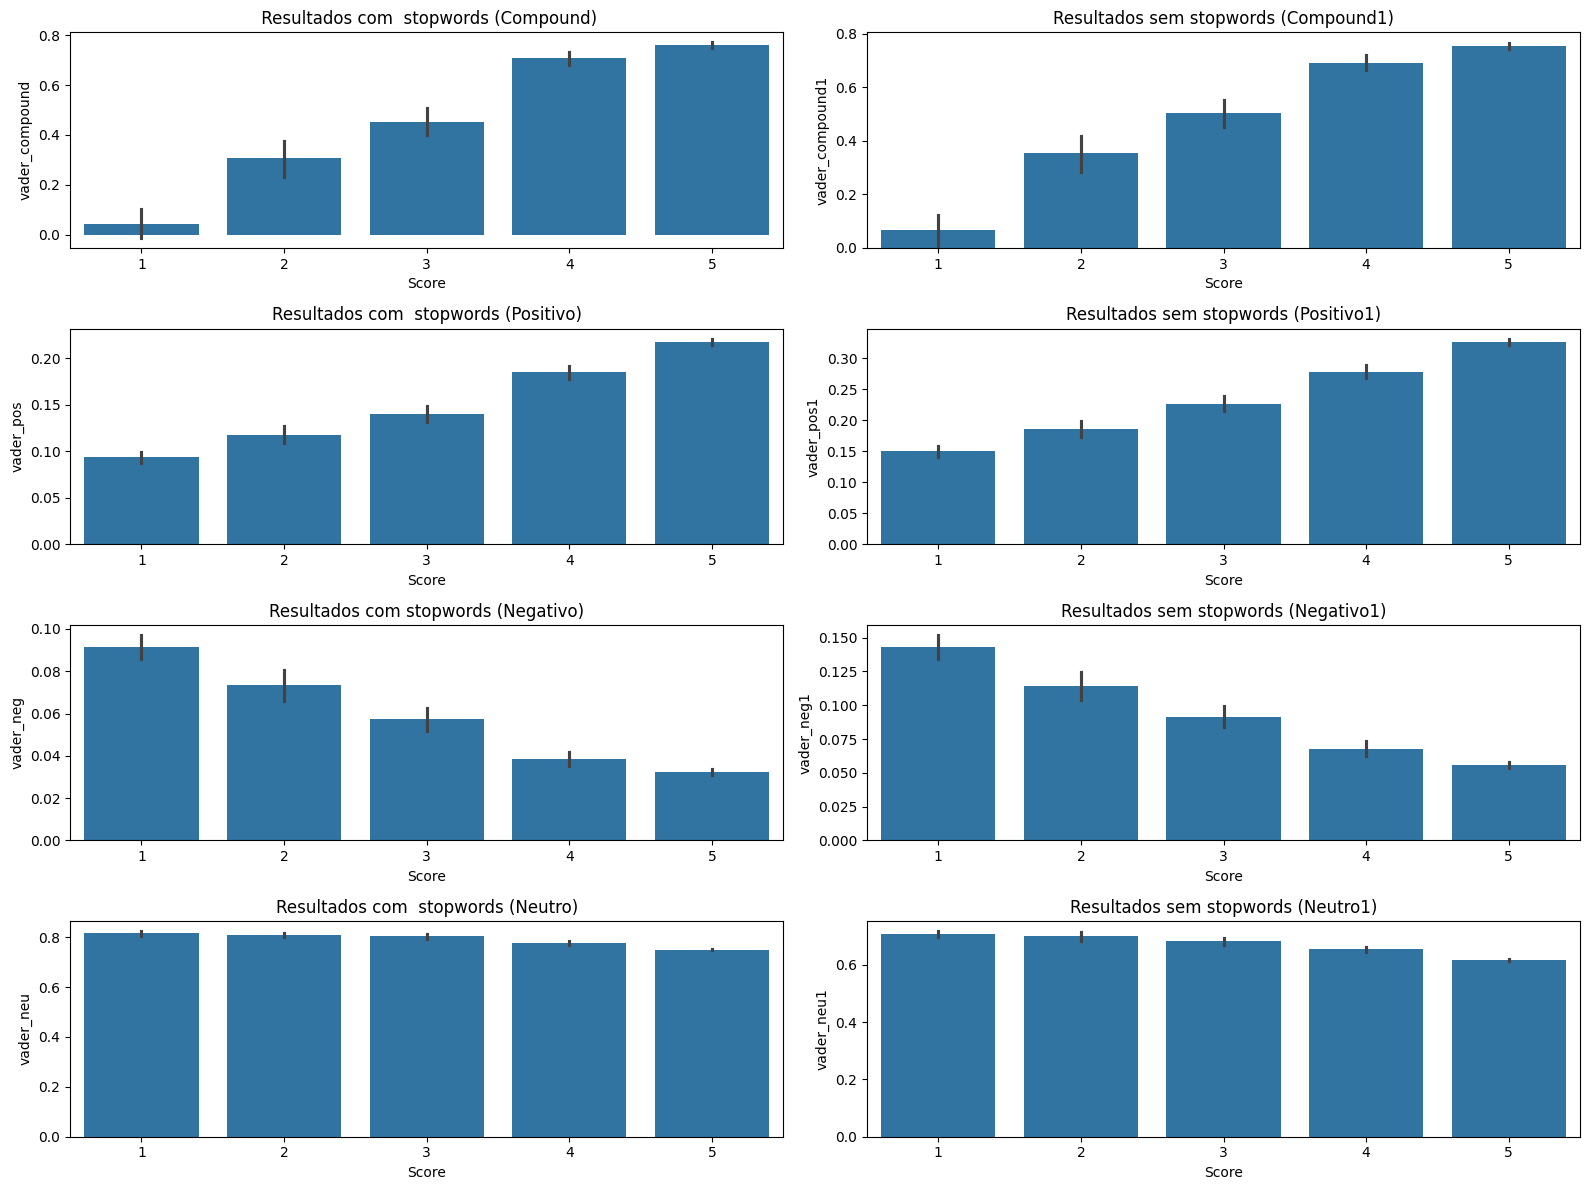

In [40]:
#entendimento via grafico das notas e os sentimentos negativos, positivos e neutros


# Criando a figura e os subplots
fig, ax = plt.subplots(4, 2, figsize=(16, 12))

# Plotando os gráficos de barras
sns.barplot(data=df_sentiment, x="Score", y="vader_compound", ax=ax[0, 0])
ax[0, 0].set_title(" Resultados com  stopwords (Compound)")

sns.barplot(data=df_sentiment, x="Score", y="vader_compound1", ax=ax[0, 1])
ax[0, 1].set_title("Resultados sem stopwords (Compound1)")

sns.barplot(data=df_sentiment, x="Score", y="vader_pos", ax=ax[1, 0])
ax[1, 0].set_title("Resultados com  stopwords (Positivo)")

sns.barplot(data=df_sentiment, x="Score", y="vader_pos1", ax=ax[1, 1])
ax[1, 1].set_title("Resultados sem stopwords (Positivo1)")

sns.barplot(data=df_sentiment, x="Score", y="vader_neg", ax=ax[2, 0])
ax[2, 0].set_title("Resultados com stopwords (Negativo)")

sns.barplot(data=df_sentiment, x="Score", y="vader_neg1", ax=ax[2, 1])
ax[2, 1].set_title("Resultados sem stopwords (Negativo1)")

sns.barplot(data=df_sentiment, x="Score", y="vader_neu", ax=ax[3, 0])
ax[3, 0].set_title("Resultados com  stopwords (Neutro)")

sns.barplot(data=df_sentiment, x="Score", y="vader_neu1", ax=ax[3, 1])
ax[3, 1].set_title("Resultados sem stopwords (Neutro1)")


plt.tight_layout()

plt.show()



In [41]:
#entendendo se existe alguma discrepancia entre score e compound
#ex: score ser 5 e compound ser negativo

df_sentiment.loc[(df_sentiment["vader_compound1"]<0)& (df_sentiment["Score"]==5)]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,...,quarter,year,vader_neg,vader_neu,vader_pos,vader_compound,vader_neg1,vader_neu1,vader_pos1,vader_compound1
39,375314,B000G17682,A14AUNY8Q3K3YD,"TROY MCDONALD ""mcdonatl""",3,4,5,1266883200,I think it is great.....,most of the reviews are comparing this to some...,...,1,2010,0.028,0.848,0.124,0.8995,0.199,0.667,0.134,-0.7119
91,555893,B001TLY7BM,A3RIX50YN2A5JJ,L. Chase,0,0,5,1348790400,A winner!,on the cat wok is one of my two cats ultimate ...,...,3,2012,0.122,0.775,0.103,-0.2003,0.181,0.667,0.152,-0.2003
108,352721,B0085YB4DU,A3DB4LTYHIWG4W,"Linda L. Wyman ""Why man""",0,0,5,1316822400,the best keurig coffee!,i was so disappointed to find out i could no l...,...,3,2011,0.094,0.717,0.189,0.7045,0.251,0.538,0.211,-0.2244
121,517172,B000VK89F2,AHR055MILIF1R,"stef ""stef""",5,5,5,1233100800,Love these! I have eaten 3 in one sitting! B...,i really really like these brownies - they are...,...,1,2009,0.077,0.897,0.026,-0.5935,0.137,0.791,0.071,-0.4254
123,258721,B0048IDQP6,A3APKIIBSTAZYU,Andrew Stein,0,0,5,1333065600,Really great sauce,"tasty, easy to use, ingredient list full of ac...",...,1,2012,0.122,0.798,0.080,-0.1386,0.146,0.758,0.096,-0.1386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4844,276103,B000FBMFDO,A1OJYBKQS60EJP,S. P.,1,2,5,1297382400,Hallalujah,"best trap on the market. yes, you have to exca...",...,1,2011,0.259,0.589,0.152,-0.9117,0.360,0.402,0.238,-0.8832
4873,330993,B001D0676C,A2WJ3CIIB00DN9,"S. Berumen ""funloving""",1,1,5,1297814400,Pizza once again!,i really do like this pizza crust mix. i use ...,...,1,2011,0.055,0.777,0.167,0.9240,0.190,0.675,0.135,-0.5707
4883,373000,B000E4C2PI,A30TC1YW7GPAU,carol p.,0,1,5,1335398400,"Gluten Free, Sugar Free, Natural life!","staying on a gluten free, sugar free diet isn'...",...,2,2012,0.140,0.747,0.113,-0.4556,0.199,0.640,0.161,-0.4556
4905,138534,B0089SPENI,AV0SKM1SJ40IB,kimmer65,0,0,5,1326326400,A great plain tea,i have been looking for just a pain black tea ...,...,1,2012,0.131,0.717,0.151,-0.0423,0.251,0.561,0.188,-0.1744


In [42]:
df_sentiment["Text"][39]

'most of the reviews are comparing this to some very unhealthy versions (like "my local restaurant") which is not fair.  it is about as healthy as you can get and still use real ingredients.  i like that it is not so loaded with salt (as others have complained).  it has a delicate flavor, and i didn\'t notice any aftertaste.  it was a little light in the veggies, but doesn\'t really need them to be good.  if you want taste at "all costs" then this is not for you.  if you generally eat healthy and are not addicted to salt you will like this soup very much.  i bought a can (at a local store) and ate it later that day, i went back to the store the next day for another can.'